# Network Compression with PPO-Clip

With all the hardware accelerations available to us today, many researchers are resorting to larger and larger models to solve their problems. However, larger models also mean more memory usage, longer training and inference time, and more limitations in productionization (for instance, [AWS Lambda](https://docs.aws.amazon.com/lambda/latest/dg/limits.html) only allows 512MB in temporary storage).

Techniques like [knowledge distillation](https://arxiv.org/abs/1503.02531) and [pruning](https://arxiv.org/abs/1611.06440) have been used to reduce the parameters of neural networks. Here we will adapt a layer removal technique from the paper [N2N Learning: Network to Network Compression via Policy Gradient Reinforcement Learning](https://arxiv.org/pdf/1709.06030.pdf) (See codes [here](https://github.com/anubhavashok/N2N)) to compress a VGG-like network to achieve 5x compression and comparable accuracy on [Fashion-MNIST dataset](https://www.kaggle.com/zalando-research/fashionmnist/kernels).

![DistilBERT](https://miro.medium.com/max/4140/1*IFVX74cEe8U5D1GveL1uZA.png)
Image from [HuggingFace Blog](https://medium.com/huggingface/distilbert-8cf3380435b5)

In [ ]:
# #uncomment if you are running from colab
# %tensorflow_version 2.x
# !pip install tensorflow-probability==0.8
# import tensorflow_probability as tfp
# !git clone https://github.com/cstorm125/lepetite.git
# !mv lepetite lepetite_folder
# !mv lepetite_folder/lepetite .
# !ls

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm_notebook
from datetime import datetime

## Fashion-MNIST

> Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. Zalando intends Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.

In [15]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train, x_valid = x_train[:50000,:,:,None], x_train[50000:,:,:,None]
y_train, y_valid = y_train[:50000], y_train[50000:]
x_test = x_test[:10000,:,:,None]
x_train.shape, y_train.shape, x_valid.shape, y_valid.shape, x_test.shape, y_test.shape

((50000, 28, 28, 1),
 (50000,),
 (10000, 28, 28, 1),
 (10000,),
 (10000, 28, 28, 1),
 (10000,))

Here we use a VGG-like network architecture with each layer being a convolution layer then a max-pooling layer. The state of each layer is described by the tuple `(layer_type, filter_size, stride, output_filters)`.

In [16]:
'''
Translated to TF2 from
VGG11/13/16/19 in Pytorch (https://github.com/anubhavashok/N2N/blob/544f5dd6c9c023c81b9c7b8ff5c8ccc1c895c66d/model/vgg.py)
'''
import tensorflow as tf
from tensorflow.keras import layers,Model

class VGGLike(Model):
    def __init__(self, action = [1 for i in range(10)], 
        #(layer type,kernel/pool size, stride, filters)
        parent_states=[(1,9,1,64),(2,2,2,0), 
                      (1,7,1,128),(2,2,2,0),
                      (1,5,1,256),(2,2,2,0),
                      (1,3,1,512),(2,2,2,0),
                      (1,3,1,1024),(2,2,2,0)]):
        super(VGGLike, self).__init__()
        self.action = action
        self.parent_states = parent_states
        self.child_states = []
        for i,a in enumerate(action):
          if a == 1:
            self.child_states.append(parent_states[i])
          else:
            self.child_states.append((0,0,0,0))
        self.features = self._make_layers()
        self.head = tf.keras.Sequential()
        self.head.add(layers.Dense(10))

    def _make_layers(self):
      m = tf.keras.Sequential()
      for s in self.child_states:
        if s[0]==2:
          m.add(layers.MaxPool2D(pool_size=s[1], 
                                 strides=s[2], 
                                 padding='same'))
        elif s[0]==1:
          m.add(layers.Conv2D(filters=s[3], 
                              kernel_size=s[1], 
                              strides=s[2],
                              padding='same'))
          m.add(layers.ReLU())
        else:
          pass
      m.add(layers.AvgPool2D(pool_size=1, strides=1, padding='same'))
      m.add(layers.Flatten())
      return m
  
    def call(self, x):
        x = self.features(x)
        x = self.head(x)
        return x

**Coding Assignment** Train the `VGGLike` architecture above and find out the accuracy on the test set.

In [18]:
#dataset objects
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))\
    .shuffle(buffer_size=y_train.shape[0]).batch(500)
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,y_valid))\
    .batch(500)
test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test))\
    .batch(500)

'''
Fill in the codes
'''
#loss
# loss_fn = 
#optimizer
# optimizer = 
#model
# parent_model = 

In [22]:
#training loop
start_time = datetime.now()
for e in tqdm_notebook(range(5)):
    for i,(x,y) in enumerate(train_ds):
    '''
    Fill in the codes
    '''
#         with tf.GradientTape() as tape:
#             preds = 
#             train_loss = 
#             gradients = 
        #update 
        optimizer.apply_gradients(zip(gradients, parent_model.trainable_weights))

    #validation loop
    valid_preds = []
    valid_ys = []
    for i,(x,y) in enumerate(valid_ds):
    '''
    Fill in the codes
    '''
#         preds = 
#         valid_loss = 
        valid_preds.append(preds)
        valid_ys.append(y)

    #concat valid preds and ys
    valid_preds = tf.concat(valid_preds,0)
    valid_ys = tf.concat(valid_ys,0)
    #log
    print(f'epoch {e} - Train Loss: {train_loss};\
    Valid Loss: {valid_loss};\
    Valid Acc: {(tf.argmax(valid_preds,1)==tf.cast(valid_ys,tf.int64)).numpy().mean()}')
print(f'Training done in {datetime.now() - start_time}')

## [Knowledge Distillation](https://arxiv.org/abs/1503.02531)

[N2N paper](https://arxiv.org/pdf/1709.06030.pdf) proposed two-stage procedure to network compression: layer removal and layer shrinkage. Both of these steps require that we retrain the child model with knowledge distillation. Below is a function excerpt from our `LayerRemoverEnv` used to perform layer removal. Notice that when training our child model we not only use the cross-entropy loss with hard labels but also mean squared loss between predictions of parent and child models.

In [23]:
def train_child(self, action, nb_epoch=1, lamb=0.9, verbose=False):
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3, amsgrad=True)
    start_time = datetime.now()
    for e in range(nb_epoch):
        for i,(x,y) in enumerate(self.train_ds):
            epoch_train_loss = []
            preds_parent = self.parent_model(x) 
            with tf.GradientTape() as tape:
                preds = self.child_model(x)
                cce_loss = self.cce_fn(y, preds)
                mse_loss = self.mse_fn(preds_parent, preds)
                train_loss = lamb * mse_loss + (1-lamb) * cce_loss
                epoch_train_loss.append(train_loss)
                #record gradients
                gradients = tape.gradient(train_loss, self.child_model.trainable_weights)
            #update 
            optimizer.apply_gradients(zip(gradients, self.child_model.trainable_weights))

## Environment

The layer removal environment is configured as follows:

![layer removal](https://i.ibb.co/pXJTM3n/Screen-Shot-2562-11-13-at-23-11-42.png)

**Conceptual Assignment** What should be the state, action, reward, and timestep for this environment?

* state:
* action:
* reward:
* timestep:

**Coding Assigment** Complete the following reward function based on the [N2N paper](https://arxiv.org/pdf/1709.06030.pdf).

In [ ]:
def get_reward(self, acc_test, nb_params):
    '''
    Fill in the codes
    '''
    pass

In [26]:
from lepetite.environments import LayerRemoverEnv
env = LayerRemoverEnv(VGGLike, (x_train,y_train), (x_valid,y_valid), (x_test,y_test))
env.reset()

In [ ]:
env.step([1,0,0,0,0,0,0,0,0,0])

## PPO-Clip Agent with Multiple Discrete Actions

We can almost use the same PPO agent as we used for `CartPole-v1` earlier with two modifications:
1. The feature extraction layer must be a bidirectional RNN that takes input of shape `(nb_layers, features)`
2. To deal with multiple discrete actions, we must sum the log-probability ratio for the surrogate function as suggested by [@ikostrikov](https://github.com/ikostrikov/pytorch-a2c-ppo-acktr-gail/issues/44).

In [0]:
class PPOBernoulli(Model):
    def __init__(self, input_dim=(10, 4), hidden_dim=30, output_dim=1,
                lr = 5e-4, gamma=1, lamb=0.95, eps_clip=0.1):
        super(PPOBernoulli, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.lr = lr
        self.gamma = gamma
        self.lamb = lamb
        self.eps_clip = eps_clip

        #feature extraction
        self.features = tf.keras.Sequential()
        self.features.add(layers.Bidirectional(layers.GRU(hidden_dim, return_sequences=True), input_shape=input_dim))

    def train(self, update_times=3):
        states,actions,rewards,next_states,probs,dones  = self.make_batch()
        for i in range(update_times):
            #q targets to optimize critic
            q_targets = rewards + self.gamma * self.critique(next_states) * (1-dones)
            #advantages to optimize actor
            advantages = self.compute_gae(states,next_states,rewards,dones)

            #train
            with tf.GradientTape() as tape:
                preds = self.act(states)
                preds_a = tf.cast(actions,tf.float32) * preds + (1-tf.cast(actions,tf.float32)) * (1-preds)
                ratio = tf.reduce_sum(tf.math.exp(tf.math.log(preds_a) - tf.math.log(probs)),1)[:,None]
                surr1 = ratio * advantages
                surr2 = tf.clip_by_value(ratio, 1-self.eps_clip, 1+self.eps_clip) * advantages
                actor_loss = tf.math.minimum(surr1,surr2)
                critic_loss_fn = tf.keras.losses.MeanSquaredError()
                critic_loss = critic_loss_fn(q_targets, self.critique(states))
                loss = -actor_loss + critic_loss
                loss = tf.reduce_mean(loss)
                gradients = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(gradients,self.trainable_weights))
            self.loss_lst.append(loss.numpy())

## Layer Remover In Action

In [9]:
from lepetite.environments import LayerRemoverEnv
from lepetite.agents import PPOBernoulli
from lepetite.networks import VGGLike

env = LayerRemoverEnv(VGGLike, (x_train,y_train), (x_valid,y_valid), (x_test,y_test))

epoch 0 - Train Loss: 0.43244799971580505;				Valid Loss: 0.4525154232978821;				Valid Acc: 0.8202
Training done in 0:00:06.761654


In [10]:
scores = []
compressions = []
accuracies = []

agent = PPOBernoulli() 
trajectory_len = 5 #suggested by N2N paper

for e in tqdm_notebook(range(5)):
    state = env.reset()
    done = False
    best_reward = -1
    best_action = [1 for i in range(10)]
    best_info = {}
    while not done:
        for t in range(trajectory_len):
            prob = agent.act(state[None,:])
            m = tfp.distributions.Bernoulli(prob)
            action = m.sample().numpy()[0]
            next_state, reward, done, info = env.step(action)
            
            #logging
            scores.append(reward)
            compressions.append(info['compression ratio'])
            accuracies.append(info['accuracy ratio'])
            if reward > best_reward:
                best_reward = reward
                best_action = action
                best_info = info
            #add
            agent.add(next_state,action,reward,next_state,prob[0,:].numpy(),done)

            #transition
            state = next_state
            if done: break
        agent.train()
    print(f'Episode {e}: best reward is {best_reward}; best action is {best_action}; best info is {info}')

Episode 0: best reward is 0.9178498560355917; best action is [1 1 0 0 0 1 0 1 1 1]; best info is {'compression ratio': 0.9107283837233646, 'accuracy ratio': 0.9252233508750458}
Episode 1: best reward is 0.9327869614342922; best action is [1 1 1 1 0 0 1 1 0 1]; best info is {'compression ratio': 0.857403017208159, 'accuracy ratio': 0.9521478399216742}
Episode 2: best reward is 0.9396483728522519; best action is [1 1 0 0 0 1 1 0 0 1]; best info is {'compression ratio': 0.9048990046054898, 'accuracy ratio': 0.8860604577163137}
Episode 3: best reward is 0.8460200921676347; best action is [0 1 1 1 1 0 1 0 0 1]; best info is {'compression ratio': 0.7160271211863459, 'accuracy ratio': 0.9105372659405213}
Episode 4: best reward is 0.9536431106846246; best action is [1 0 0 1 1 1 0 1 0 1]; best info is {'compression ratio': 0.7735855137686852, 'accuracy ratio': 0.9521478399216742}


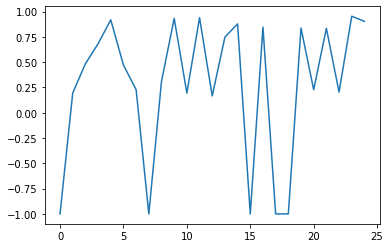

In [11]:
plt.plot(scores)